In [2]:
#импорт библиотек
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller


1. 
    * Прочитайте исходный файл с данными. 
    * Визуализируйте исходный временной ряд
    * Сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.
    * Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [29]:
#Прочитаем данные и приведем в удобный вид (Год в формате номера года, названия фич к одному регистру)
data = pd.read_csv('ghana_gdp.csv', parse_dates=['year'])
data = data.rename({'GDP (current US$)':'GPD'}, axis=1)
data['year'] = pd.to_datetime(data['year'])
#data['year'] = data['year'].dt.year
data = pd.DataFrame(data['GPD'].values, index=data['year']).rename({0:'gpd'},axis=1)
data.head(3)

,gpd
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09


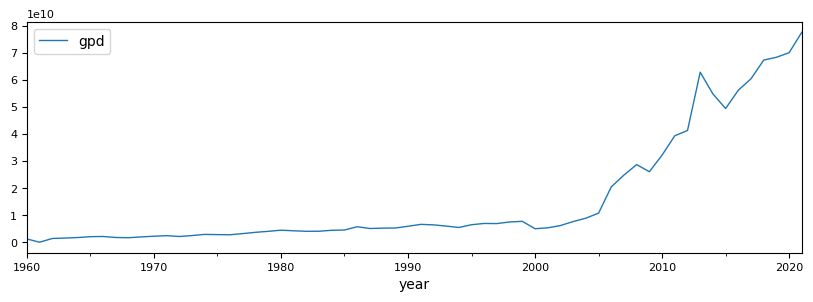

In [30]:
# Визуализируем ряд как он есть
%matplotlib inline

plt.rcParams["figure.figsize"] = 10, 3
plt.rcParams["font.size"] = 10
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["lines.linewidth"] = 1

data.plot()
plt.show()

- - -
    Выводы:
    - Сезонности не видно (да и оно логично, ВВП стран +/- расчет в длинной динамике по годам)
    - Тренд есть, более того график можно разделить на 2е явно выраженные части по тренду, в каждой их которых трнед примерно линейный. Виден "слом тренда" на более высокие темпы роста с середины 2000х
    - Стационарности вообще, я бы не предполагал т.к. тренд явно выражен, а значит матожидание в период 2010+, например, явно отличается от матожидания до 2000


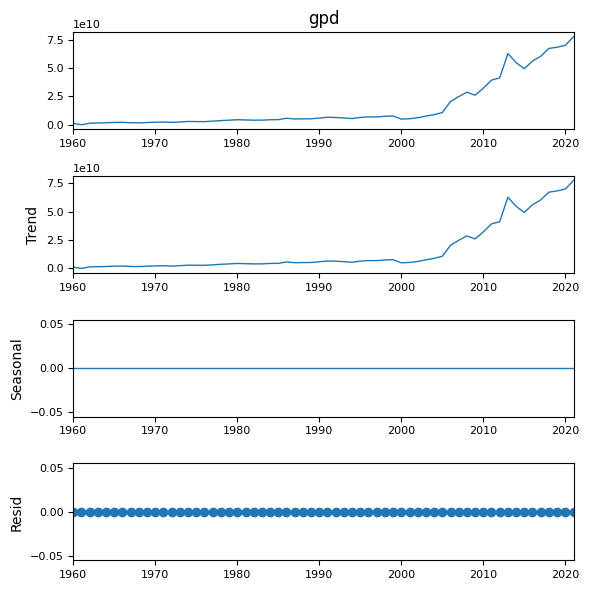

In [37]:
# Посмотрим, как на тренд и сезонную составляющую через метод сезонной декомпозиции
plt.rcParams["figure.figsize"] = 6, 6

result = seasonal_decompose(data.gpd)
result.plot()
plt.show()

- - -
    Видим, что выделяется один тренд. Рискну предположить, что модели прогнозирования сработают хорошо, т.к. у нас нет ни шумов, ни сезонности, а тренд "на глаз" состоит из двух линейных кусков

In [44]:
#Разделим выборку на тестовую и тренировочную. В тренировочную положим последние 3 года
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]

2. * Постройте модель скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.
    * Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

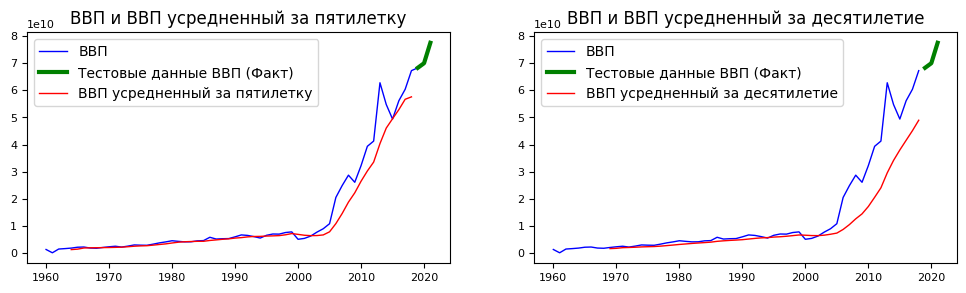

In [68]:
plt.rcParams["figure.figsize"] = 12, 3

fig, ax = plt.subplots(1, 2)

# Окно в Пятилетку
ax[0].plot(data['gpd'], color="blue", label="ВВП")
ax[0].plot(test_df['gpd'], color="green", label="Тестовые данные ВВП (Факт)", lw=3)

ax[0].plot(
    train_df['gpd'].rolling(window=5).mean(),
    color="red",
    label="ВВП усредненный за пятилетку",
)

ax[0].set_title("ВВП и ВВП усредненный за пятилетку")
ax[0].legend()

# Окно в Десятилетие
ax[1].plot(train_df['gpd'], color="blue", label="ВВП")
ax[1].plot(test_df['gpd'], color="green", label="Тестовые данные ВВП (Факт)", lw=3)

ax[1].plot(
    train_df['gpd'].rolling(window=10).mean(),
    color="red",
    label="ВВП усредненный за десятилетие",
)

ax[1].set_title("ВВП и ВВП усредненный за десятилетие")
ax[1].legend()

plt.show()

- - -
    Выводы:
    - Чем больше период окна, тем больше MA отстает от изменения тренда
    - В целом MA конечно плохо прогнозирует такую картинку, когда тренд резкий, оценка занижена или завышена. Тут вопрос и в том как "продалять" правильно красную линию скользящего среднего до прогноза и не надо ли ее "адаптировать" к более свежим данным. 
    - Тут кстати должна лучше сработать из простых модель экспоненциального сглаживания, т.к. "свежие данные" сильнее влияют. Давайте проверим эту гипотезу ниже (понятно, что тут есть явное когнитивное искажение, т.к. факт уже нарисован на картинке и я подбираю модель, которая луше предскажет видимый глазом результат, но все равно интересно):

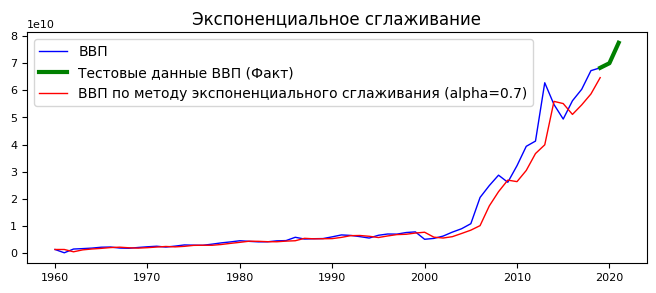

In [90]:
# Попробуем эеспоненциальное сглаживание. Тут логично его применить и интересно,ч то получится
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(train_df)
model = ses.fit(smoothing_level = 0.7, optimized = False)
#print(model.fittedvalues)

plt.rcParams["figure.figsize"] = 8, 3

fig, ax = plt.subplots(1, 1)

# Окно в Пятилетку
ax.plot(data['gpd'], color="blue", label="ВВП")
ax.plot(test_df['gpd'], color="green", label="Тестовые данные ВВП (Факт)", lw=3)

ses_graph = pd.concat([model.fittedvalues, model.forecast(1)], axis=0)
ax.plot(
    ses_graph,
    color="red",
    label="ВВП по методу экспоненциального сглаживания (alpha=0.7)",
)

ax.set_title("Экспоненциальное сглаживание")
ax.legend()


- - -
    Вывод:
    - Подгоняя модель под ответ, получили более точный прогноз (кто бы сомневался :) )
    - И все равно методы усреднения "подстраховываются", ну явно линейная часть тренда "красной линии" ниже, чем нужно

3.  * С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.
    * Параметры p и q выберите по коррелограммам ACF и PACF.
    * Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.
    * Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

4. * Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

5. * Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

6. * Сделайте выводы по полученным результатам.